Lorenzo Sala, MAT. 942481

Submitted for the course of Introduction to Data Science, M. Sc. in Stochastics and Data Science

# Classification Task: Classifying chords in Johann Sebastian Bach's Chorales.

## Introduction and data description

This assignment will make use of the dataset used in the paper [D. P. Radicioni and R. Esposito. Advances in Music Information Retrieval, chapter BREVE: an HMPerceptron-Based Chord Recognition System. Studies in Computational Intelligence, Zbigniew W. Ras and Alicja Wieczorkowska (Editors), Springer, 2010](https://www.openml.org/search?type=data&status=active&id=4552&sort=runs). 

It is a .arff file which contains, the labeling of a number of harmonic events from JSB's Chorales, assigning to each one of them a chord name which consists of a root note (C, C#, D, D#, ...) and a quality (major, minor, dominant seventh, ...). In the original data set each data point has 16 features, with the 17th being the target feature (the chord label). These features are:

    1. the chorale ID;
    2. the "event number", which represent the order in which the harmonic event appeared in the chorale;
    3 - 14. the presence (or absence) of each of the 12 scale tones using dummy variables;
    15. the root note of the event;
    16. the event duration expressed as quarter notes.

For simplicity's sake, I will operate on a simplified version of this dataset: instead of classifying the complete chord name I will focus on the chord's quality. This means that the root note feature will be dropped. Features 3-14 could be translated from absolute to relative (i.e. from note names to note intervals with respect to the root note) but since that would have made the classification task less compelling (it is always possible to determine a chord only based on its intervals) I chose to utilize the absolute note names. This means that an ambiguity caused by eventual chord inversions and homophony may have been introduced, but I deemed interesting to verify whether the classification task would prove robust enough for that.

## Data pre-processing

I start by importing the file, writing it into a pandas data frame and simplifying the features and labels.

In [ ]:
# packages cell

import pandas as pd
import numpy as np
import umap.umap_ as umap
from scipy.io import arff
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.naive_bayes import ComplementNB
from wittgenstein import RIPPER

In [2]:
# load arff file
data, meta = arff.loadarff("jsbachchoralharmony.arff")
df = pd.DataFrame(data)

# decode bytes (to prevent errors in the regular expression mapping)
def decode_if_bytes(x):
    if isinstance(x, bytes):
        return x.decode("utf-8")
    return x

df = df.map(decode_if_bytes)

# drop the root feature (feature 15)
df = df.drop(columns=["V15"])

# I map the chords name to another name which doesn't comprise the root note. I use the extended names of the chords.
def drop_notenames(chord):
    chord = chord.decode("utf-8") if isinstance(chord, bytes) else chord

    # delete _'s
    chord = chord.replace("_", "").strip()

    # major
    if chord.endswith("M"):
        return "Major"
    # minor
    elif chord.endswith("m"):
        return "Minor"
    # dominant 7th
    elif chord.endswith("M7"):
        return "Dominant7th"
    # min 7th
    elif chord.endswith("m7"):
        return "Minor7"
    # sus
    elif chord.endswith("m4"):
        return "Sus4_min"
    elif chord.endswith("M4"):
        return "Sus4_maj"
    # diminished
    elif chord.endswith("d"):
        return "Diminished"
    # half diminished
    elif chord.endswith("d7"):
        return "HalfDiminished"
    # dim 6th
    elif chord.endswith("d6"):
        return "Diminished6"
    # maj 6th
    elif chord.endswith("M6"):
        return "Major6"
    # min 6th
    elif chord.endswith("m6"):
        return "Minor6"

df["V17"] = df["V17"].apply(drop_notenames)
# i save the features in variable x_full and substitute YES and NO with 0 and 1
x_full = df.loc[:, "V2":"V16"].replace({"YES": 1, " NO": 0}) # downcasting will be deprecated in future versions of pandas, this generates a warning

# I save the labels in variable y_full
y_full = df["V17"]

print(x_full.head())
print(y_full.head())

    V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V16
0  1.0   1   0   0   0   0   1   0    0    0    1    0    0  3.0
1  2.0   1   0   0   0   1   0   0    1    0    0    0    0  5.0
2  3.0   1   0   0   0   1   0   0    1    0    0    0    0  2.0
3  4.0   1   0   0   0   0   1   0    0    0    1    0    0  3.0
4  5.0   1   0   0   0   0   1   0    0    0    1    0    0  2.0
0    Major
1    Major
2    Major
3    Major
4    Major
Name: V17, dtype: object


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_74036\2252442163.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_full = df.loc[:, "V2":"V16"].replace({"YES": 1, " NO": 0}) # downcasting will be deprecated in future versions of pandas, this generates a warning


Now we have the simplified data set. To get an idea of label distribution, we can plot an histogram.

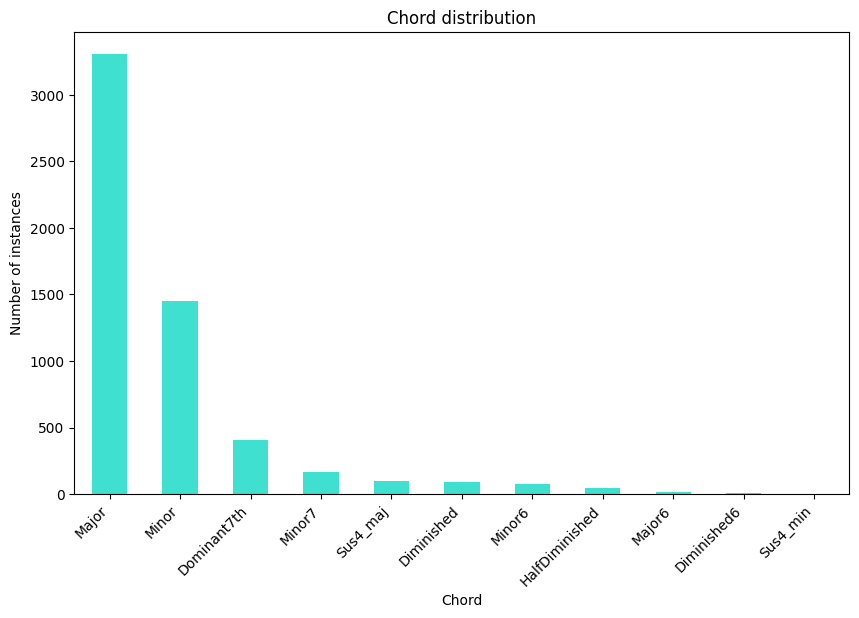

In [3]:
label_counts = y_full.value_counts()
plt.figure(figsize=(10,6))
label_counts.plot(kind='bar', color='turquoise')
plt.title("Chord distribution")
plt.xlabel("Chord")
plt.ylabel("Number of instances")
plt.xticks(rotation=45, ha='right')
plt.show()

We see that the vast majority of chords are either major or minor (as one would expect). I chose to remove from the dataset all data points whose label has less than 20 instances, since that could compromise data set split, cross validation and rule-based decision.

In [4]:
# count frequencies and save labels to keep
counts = y_full.value_counts()
valid_labels = counts[counts >= 20].index

# filter the dataframe
x = x_full[y_full.isin(valid_labels)]
y = y_full[y_full.isin(valid_labels)]

print("Original size:", len(y_full))
print("Filtered size:", len(y))
print("Remaining labels:", list(valid_labels))

Original size: 5665
Filtered size: 5640
Remaining labels: ['Major', 'Minor', 'Dominant7th', 'Minor7', 'Sus4_maj', 'Diminished', 'Minor6', 'HalfDiminished']


Of course, data points are not bi-dimensional. This means that we cannot plot them directly on in a two dimensional plot but we can get an idea of the general structure by using a dimension reduction procedure. In this case I chose UMAP instead of a common PCA since UMAP is non linear and it has been shown to perform better on categorical/binary variables and should better preserve the neighbourhood structure of the data. Either way, a plot with clear cluster structure is not expected.

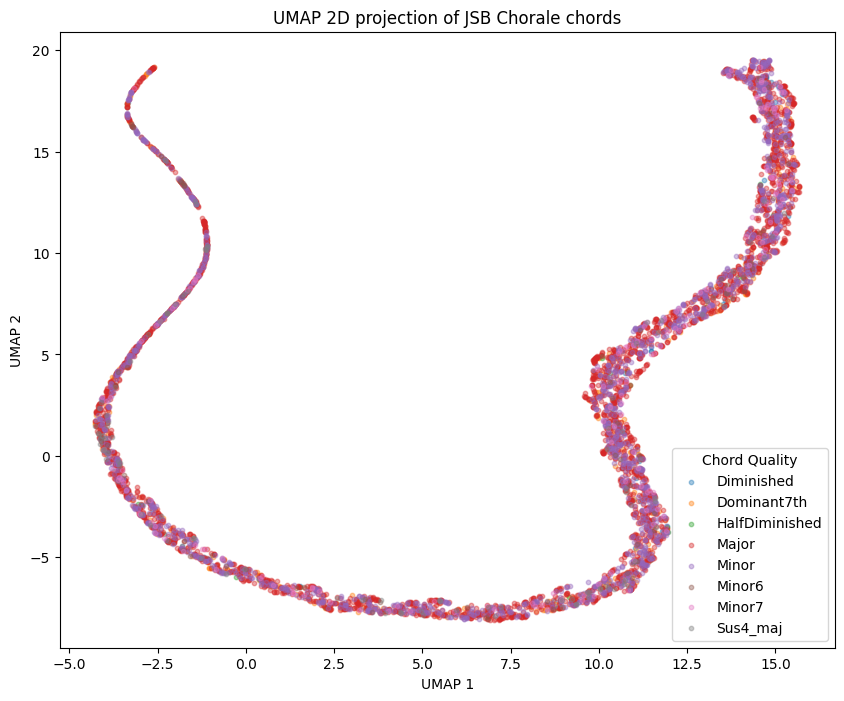

In [5]:
# create the UMAP reducer
reducer = umap.UMAP(n_components=2) # this is from "umap-learn", not "umap"
x_embedded = reducer.fit_transform(x)

# convert labels to a pandas categorical for coloring
labels = pd.Categorical(y)

plt.figure(figsize=(10,8))

# scatter plot with colors for each chord quality
for i, chord_label in enumerate(labels.categories):
    mask = labels == chord_label
    plt.scatter(
        x_embedded[mask, 0], 
        x_embedded[mask, 1], 
        label=chord_label,
        s=10, 
        alpha=0.4
    )

plt.legend(title="Chord Quality")
plt.title("UMAP 2D projection of JSB Chorale chords")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

The plot is not very telling, but this was to be expected since the data have binary dimension and are rather sparse.

I also define some utility functions to display the result of the classification tasks.

In [6]:
def print_classification_metrics(test_labels, predicted_labels, average='binary', prefix=""):
    accuracy = metrics.accuracy_score(test_labels, predicted_labels)
    precision = metrics.precision_score(test_labels, predicted_labels, average=average,zero_division=0)
    recall = metrics.recall_score(test_labels, predicted_labels, average=average,zero_division=0)
    F1 = metrics.f1_score(test_labels, predicted_labels, average=average,zero_division=0)
    print(prefix+"Accuracy: {:.5f}".format(accuracy), "Precision: {:.5f}".format(
        precision), "Recall: {:.5f}".format(recall), "F1: {:.5f}\n".format(F1), sep='\n')


def show_tree(classifier):
    plt.figure(figsize=(200, 200))
    plot_tree(
        classifier, 
        filled=True, 
        rounded=True, 
        class_names=y.unique(), 
        feature_names=list(x),
        fontsize=8
            )

## Decision tree classifier
I start with a simple decision tree classifier.

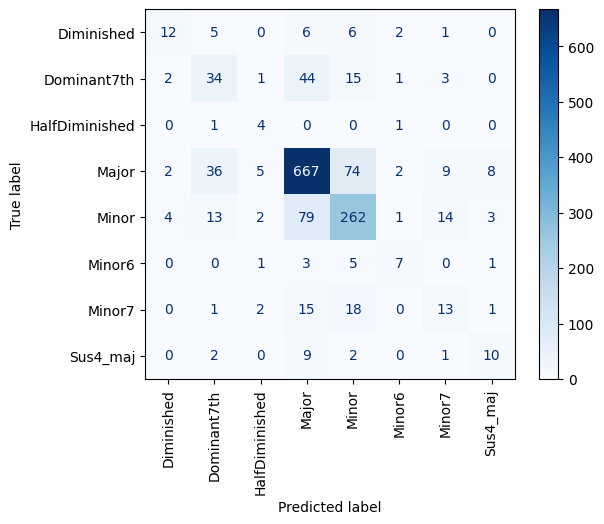

                precision    recall  f1-score   support

    Diminished       0.60      0.38      0.46        32
   Dominant7th       0.37      0.34      0.35       100
HalfDiminished       0.27      0.67      0.38         6
         Major       0.81      0.83      0.82       803
         Minor       0.69      0.69      0.69       378
        Minor6       0.50      0.41      0.45        17
        Minor7       0.32      0.26      0.29        50
      Sus4_maj       0.43      0.42      0.43        24

      accuracy                           0.72      1410
     macro avg       0.50      0.50      0.48      1410
  weighted avg       0.71      0.72      0.71      1410



In [7]:
# split dataset into training and test sets
training_data, test_data, training_labels, test_labels = train_test_split(
    x, y, test_size=0.25, random_state=2)

# initialize classifier with hyperparameters
classifier = DecisionTreeClassifier()

# train classifier with training set
classifier.fit(training_data, training_labels)

# use trained classifecation model to predict classes on test set
predicted = classifier.predict(test_data)

# sort labels and compute confusion matrix
labels_list = sorted(y.unique()) 
cm = confusion_matrix(test_labels, predicted, labels=labels_list)

# plot the confusion matrix
cmp = ConfusionMatrixDisplay(cm, display_labels=labels_list)
cmp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

# print classification report
print(classification_report(test_labels, predicted, zero_division=0))

As we can see, the most numerous chords (major and minor) get predicted the most, but the other chords, being much sparser, tend not to be predicted as they should. A nested K-fold cross validation can help better understand the optimal hyperparameters and to have a more solid graps of the efficiency of the decision tree method. I use Stratified K-Fold cross validation to counter the fact that the classes are heavily unbalanced. For this same reason, we are interested in the macro average rather than the micro average.

In [8]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model and hyperparamenters grid
classifier = DecisionTreeClassifier()
p_grid = {'criterion': ["gini", "entropy"],
          'max_depth': [3, 7, 10],
          'min_samples_leaf': [1, 2, 5]}

history = []
counter = 1

# cross validation
for train_index, test_index in cv_outer.split(x, y):
    print('\nNestedCV: {} of outer fold {}'.format(counter, cv_outer.get_n_splits()))

    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomizedSearchCV(classifier, param_distributions=p_grid,
                               scoring='accuracy', cv=cv_inner)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)

    acc_train = accuracy_score(y_train, pred_training)
    acc_test = accuracy_score(y_test, pred_test)

    print("Best set of parameters:", model.best_params_)
    print("Best inner cv score:", model.best_score_)
    print("Training accuracy:", acc_train)
    print("Test accuracy:", acc_test)

    history.append(acc_test)
    counter += 1

print('\nOverall test performance: {:.3f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 5
Best set of parameters: {'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7400274522225743
Training accuracy: 0.8120567375886525
Test accuracy: 0.7402482269503546

NestedCV: 2 of outer fold 5
Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7406931317878567
Training accuracy: 0.8477393617021277
Test accuracy: 0.7641843971631206

NestedCV: 3 of outer fold 5
Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7413607757340032
Training accuracy: 0.8512854609929078
Test accuracy: 0.7411347517730497

NestedCV: 4 of outer fold 5
Best set of parameters: {'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}
Best inner cv score: 0.7322686389050541
Training accuracy: 0.8098404255319149
Test accuracy: 0.7677304964539007

NestedCV: 5 of outer fold 5
Best set of parameters: {'min_samples_leaf': 1, 'max_depth': 10

The final value of 0.75 means that in average the decision tree will classify 75% of new samples in the right way. The Gini impurity coefficient appears to be the optimal one to use in the decision tree.

## K-nearest neighbour classifier

I start with a simple K-nearest neighbour classifier.

## Macro metrics training##
Accuracy: 0.69031
Precision: 0.64231
Recall: 0.27974
F1: 0.32766


## Macro metrics test##
Accuracy: 0.58156
Precision: 0.26975
Recall: 0.20482
F1: 0.21012

                precision    recall  f1-score   support

    Diminished       0.33      0.06      0.11        32
   Dominant7th       0.35      0.11      0.17       100
HalfDiminished       0.40      0.33      0.36         6
         Major       0.61      0.89      0.72       803
         Minor       0.46      0.25      0.32       378
        Minor6       0.00      0.00      0.00        17
        Minor7       0.00      0.00      0.00        50
      Sus4_maj       0.00      0.00      0.00        24

      accuracy                           0.58      1410
     macro avg       0.27      0.20      0.21      1410
  weighted avg       0.51      0.58      0.51      1410



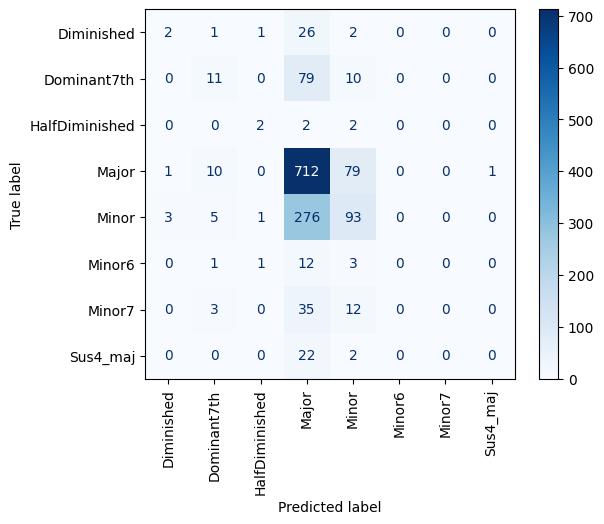

In [9]:
training_data, test_data, training_labels, test_labels = train_test_split(
    x, y, test_size=0.25, random_state=2)

# initialize classifier with hyperparameters
classifier = KNeighborsClassifier(n_neighbors=5)

# train classifier with training set
classifier.fit(training_data, training_labels)

predicted = classifier.predict(training_data)

# plot trained classifer
print_classification_metrics(training_labels, predicted, average='macro', prefix="## Macro metrics training##\n")

# use trained classifecation model to predict classes on test set
predicted = classifier.predict(test_data)

# plot trained classifer
print_classification_metrics(test_labels, predicted, average='macro', prefix="\n## Macro metrics test##\n")

# print in depth test metrics
print(classification_report(test_labels, predicted, zero_division=0))

# confusion matrix plot
labels_list = sorted(y.unique()) 
cm = confusion_matrix(test_labels, predicted, labels=labels_list)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels_list)
cmp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

We can see that the overall precision and accuracy have decreased greatly. This is to be expected as well, since Knn performs well when classes are not too many and when distances are easily computable. Again, the presence of binary features does not help to clearly divide the feature space. Curiously we also note that a lot minor chords have been misclassified as major. This is clearly due to the fact that when two different data points are similar the most common class tends to prevail and minor chords are only different from major chords by one note.

I also perform K-fold cross validation (as before, with six folds). This will also help us to find the best hyperparameters.

In [10]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

classifier = KNeighborsClassifier()
p_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # serve solo se metric="minkowski"
}

history = []
counter = 1

for train_index, test_index in cv_outer.split(x, y):
    print('\nNestedCV: {} of outer fold {}'.format(counter, cv_outer.get_n_splits()))

    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomizedSearchCV(classifier, param_distributions=p_grid,
                               scoring='accuracy', cv=cv_inner)
    model.fit(x_train, y_train)

    pred_test = model.predict(x_test)
    pred_training = model.predict(x_train)

    acc_train = accuracy_score(y_train, pred_training)
    acc_test = accuracy_score(y_test, pred_test)

    print("Best set of parameters:", model.best_params_)
    print("Best inner cv score:", model.best_score_)
    print("Training accuracy:", acc_train)
    print("Test accuracy:", acc_test)

    history.append(acc_test)
    counter += 1

print('\nOverall test performance: {:.3f}'.format(np.mean(history)))


NestedCV: 1 of outer fold 5
Best set of parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 7, 'metric': 'minkowski'}
Best inner cv score: 0.6026158186680025
Training accuracy: 0.6963652482269503
Test accuracy: 0.6347517730496454

NestedCV: 2 of outer fold 5
Best set of parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'metric': 'manhattan'}
Best inner cv score: 0.6314288660857009
Training accuracy: 0.9878102836879432
Test accuracy: 0.6382978723404256

NestedCV: 3 of outer fold 5
Best set of parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'metric': 'manhattan'}
Best inner cv score: 0.6425094474442178
Training accuracy: 0.9867021276595744
Test accuracy: 0.6312056737588653

NestedCV: 4 of outer fold 5
Best set of parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 7, 'metric': 'manhattan'}
Best inner cv score: 0.6318681507564095
Training accuracy: 0.9851507092198581
Test accuracy: 0.6702127659574468

NestedCV: 5 of outer fold 5
Best set of paramete

We see that there is no clear cut between which metric we should adopt, while the optimal number of neighbours seems to be around 7 or 9. Anyway the overall test performance is worse than before.

## Macro metrics train ## 
Accuracy: 0.36147
Precision: 0.17425
Recall: 0.17919
F1: 0.15921

## Macro metrics test ## 
Accuracy: 0.35603
Precision: 0.15498
Recall: 0.17037
F1: 0.14460

                precision    recall  f1-score   support

    Diminished       0.00      0.00      0.00        32
   Dominant7th       0.10      0.34      0.15       100
HalfDiminished       0.07      0.17      0.10         6
         Major       0.60      0.38      0.47       803
         Minor       0.31      0.41      0.36       378
        Minor6       0.00      0.00      0.00        17
        Minor7       0.17      0.06      0.09        50
      Sus4_maj       0.00      0.00      0.00        24

      accuracy                           0.36      1410
     macro avg       0.15      0.17      0.14      1410
  weighted avg       0.44      0.36      0.38      1410



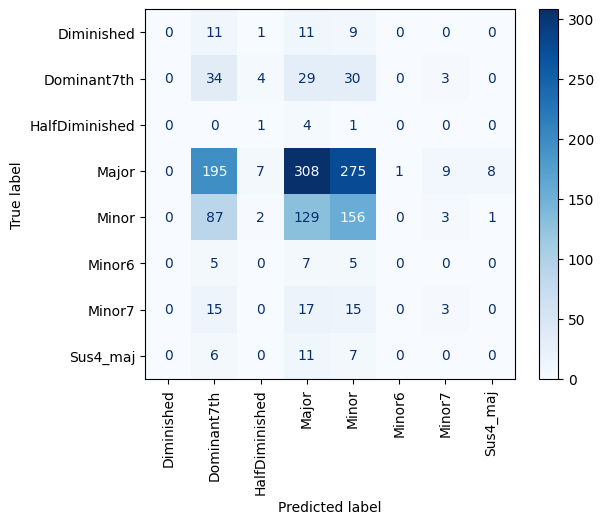

In [ ]:
# initialize classifier with hyperparameters
classifier = ComplementNB()

# train classifier with training set
classifier.fit(training_data, training_labels)

# use trained classifecation model to predict classes on test set
predicted = classifier.predict(test_data)

# print classification metrics 
pred_train = classifier.predict(training_data)
print_classification_metrics(
    training_labels, pred_train, average='macro', prefix="## Macro metrics train ## \n")

pred_test = classifier.predict(test_data)
print_classification_metrics(
    test_labels, pred_test, average='macro', prefix="## Macro metrics test ## \n")

# print in depth test metrics
print(classification_report(test_labels, predicted, zero_division=0))

# confusion plot
labels_list = sorted(y.unique()) 
cm = confusion_matrix(test_labels, predicted, labels=labels_list)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels_list)
cmp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

The result here is even worse, with much more misclassified labels for the major chord. This could be due to the fact that ComplementNB works well for sparse data with counted instances (like bag-of-word in language processing). Since we have binary and numeric representations, differences between similar classes (like major/minor/dominant 7th) are not captured by the model.

I perform, as before, the cross-validation task. Since there are no significant hyperparameter to tune (there is the alpha smoothing parameter but it is a secondary parameter) I chose to perform a normal K-fold (stratified) cross validation.

In [12]:
# prepare list for final results
all_folds = []
accuracy_list = []

# split the data
cv_split = StratifiedKFold(n_splits=4, shuffle=True)

# iterate through folds
for fold, (train, test) in enumerate(cv_split.split(x, y)):
    print("Fold: ", fold)
    print("  Training set size:", len(train), "Test set size:", len(test))
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    x_train = x.iloc[train]
    x_test = x.iloc[test]
    
    classifier = ComplementNB()
    classifier.fit(x_train, y_train)

    # predict
    pred_train = classifier.predict(x_train)
    pred_test = classifier.predict(x_test)

    # put results in a dictionary (seems more appropriate than a dataframe)
    for chord in y.unique():
        metrics_dict = {
            "Chord": chord,
            "Train Precision": metrics.precision_score(y_train, pred_train, labels=[chord], average="macro", zero_division=0),
            "Train Recall": metrics.recall_score(y_train, pred_train, labels=[chord], average="macro", zero_division=0),
            "Train F1": metrics.f1_score(y_train, pred_train, labels=[chord], average="macro", zero_division=0),
            "Test Accuracy": metrics.accuracy_score(y_test, pred_test),
            "Test Precision": metrics.precision_score(y_test, pred_test, labels=[chord], average="macro", zero_division=0),
            "Test Recall": metrics.recall_score(y_test, pred_test, labels=[chord], average="macro", zero_division=0),
            "Test F1": metrics.f1_score(y_test, pred_test, labels=[chord], average="macro", zero_division=0)
        }
        all_folds.append(metrics_dict)

        accuracy_list.append(metrics.accuracy_score(y_train, pred_train))


# concatenate all results
results_df = pd.DataFrame(all_folds)

# create summary
summary = results_df.groupby("Chord").mean().reset_index()
display(summary)
print(f"Average accuracy:{np.mean(accuracy_list)}")

Fold:  0
  Training set size: 4230 Test set size: 1410
Fold:  1
  Training set size: 4230 Test set size: 1410
Fold:  2
  Training set size: 4230 Test set size: 1410
Fold:  3
  Training set size: 4230 Test set size: 1410


,Chord,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Diminished,0.000000,0.000000,0.000000,0.337057,0.000000,0.000000,0.000000
1,Dominant7th,0.107263,0.351472,0.164173,0.337057,0.099217,0.328359,0.152094
2,HalfDiminished,0.056349,0.050000,0.052765,0.337057,0.000000,0.000000,0.000000
3,Major,0.629957,0.330209,0.432898,0.337057,0.622876,0.324458,0.426586
4,Minor,0.293416,0.481763,0.363878,0.337057,0.289328,0.472098,0.358010
5,Minor6,0.040584,0.022484,0.028902,0.337057,0.077778,0.027047,0.039352
6,Minor7,0.071674,0.032654,0.041672,0.337057,0.021429,0.018750,0.020000
7,Sus4_maj,0.068051,0.032939,0.042096,0.337057,0.080808,0.039231,0.051660


Average accuracy:0.34521276595744677


## RIPPER

I decided to try another rule-based classifier method with RIPPER. Since RIPPER is basically a binary classificator, I chose a "one-vs-all" approach where I do a different classification for each chord type, using RIPPER each time to discriminate one chord from all the other ones.

In [13]:
# let's create a function that does the "one vs all tests"
def ripper_one_vs_all(x_train, x_test, y_train, y_test):
    result = []
    accuracy_list = []

    # cycle through each chord
    for chord in y_train.unique():
        # initialize classifier
        ripper_clf = RIPPER()

        # train
        ripper_clf.fit(x_train, y_train, pos_class=chord)

        # predict
        predicted_train = ripper_clf.predict(x_train)
        predicted_test = ripper_clf.predict(x_test)

        # binary labels for one-vs-all
        y_train_bin = (y_train == chord)
        y_test_bin = (y_test == chord)

        # compute metrics
        metrics_dict = {
            "Chord": chord,
            "Accuracy": metrics.accuracy_score(y_train_bin, predicted_train),
            "Train Precision": metrics.precision_score(y_train_bin, predicted_train, zero_division=0),
            "Train Recall": metrics.recall_score(y_train_bin, predicted_train, zero_division=0),
            "Train F1": metrics.f1_score(y_train_bin, predicted_train, zero_division=0),
            "Test Accuracy": metrics.accuracy_score(y_test_bin, predicted_test),
            "Test Precision": metrics.precision_score(y_test_bin, predicted_test, zero_division=0),
            "Test Recall": metrics.recall_score(y_test_bin, predicted_test, zero_division=0),
            "Test F1": metrics.f1_score(y_test_bin, predicted_test, zero_division=0),
        }

        accuracy_list.append(metrics.accuracy_score(y_train_bin, predicted_train))

        result.append(metrics_dict)

    result_df = pd.DataFrame(result)
    print(f"Average accuracy: {np.mean(accuracy_list)}")
    display(result_df)
    return result_df

I now proceed to apply the ripper method to each chord. It is important to remember that this is not technically a classification, since we are not creating partitions of the data set, but we are picking one by one the various chords among all the others.

In [14]:
training_data, test_data, training_labels, test_labels = train_test_split(
    x, y, test_size=0.25, random_state=2)

chord_ripper = ripper_one_vs_all(training_data,test_data,training_labels,test_labels)

Average accuracy: 0.9372635933806146


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Dominant7th,0.936407,0.810345,0.154098,0.258953,0.934043,0.705882,0.120000,0.205128
1,Major,0.763830,0.942908,0.639776,0.762313,0.744681,0.904936,0.616438,0.733333
2,Minor,0.864775,0.906300,0.521860,0.662338,0.858156,0.867769,0.555556,0.677419
3,Diminished,0.986761,0.562500,0.155172,0.243243,0.979433,0.800000,0.125000,0.216216
4,HalfDiminished,0.994799,0.787879,0.634146,0.702703,0.994326,0.333333,0.333333,0.333333
5,Minor7,0.974941,0.652174,0.132743,0.220588,0.959574,0.230769,0.060000,0.095238
6,Sus4_maj,0.986998,0.720000,0.467532,0.566929,0.980142,0.300000,0.125000,0.176471
7,Minor6,0.989598,0.760000,0.333333,0.463415,0.987234,0.454545,0.294118,0.357143


It's interesting to see that precision is very high (especially for frequent chords), but recall is extremely low. This means that the rule set is very strict so that when RIPPER selects a data point it's very often correct, but it selects too few of them. More frequent classes allow a more precise learning of the set of rules and that's why their precision is so high.

Similarly to before, I perform a stratified 5-fold cross validation.

In [15]:
all_folds = []
cv_split = StratifiedKFold(n_splits=5, shuffle=True) # or StratifiedKFold
for fold, (train, test) in enumerate(cv_split.split(x, y)):
    print("Fold: ", fold)
    print("  Training set size:", len(train), "Test set size:", len(test))
    y_train = y.iloc[train]
    y_test = y.iloc[test]
    x_train = x.iloc[train]
    x_test = x.iloc[test]
    chord_ripper = ripper_one_vs_all(x_train,x_test,y_train,y_test)
    all_folds.append(chord_ripper)

    results_df = pd.concat(all_folds, ignore_index=True)

print("Summary measures\n")
summary = results_df.groupby("Chord").mean()
display(summary)

Fold:  0
  Training set size: 4512 Test set size: 1128
Average accuracy: 0.9346464982269503


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Major,0.765957,0.948617,0.635161,0.760870,0.750000,0.924107,0.625378,0.745946
1,Minor,0.841977,0.841945,0.476354,0.608457,0.856383,0.851648,0.534483,0.656780
2,Dominant7th,0.941711,0.760684,0.274691,0.403628,0.925532,0.448276,0.160494,0.236364
3,Minor7,0.973183,0.800000,0.092308,0.165517,0.970745,0.500000,0.060606,0.108108
4,Sus4_maj,0.985151,0.675000,0.333333,0.446281,0.981383,0.454545,0.250000,0.322581
5,Diminished,0.985594,0.620690,0.250000,0.356436,0.979610,0.222222,0.111111,0.148148
6,HalfDiminished,0.994902,0.818182,0.486486,0.610169,0.994681,0.833333,0.500000,0.625000
7,Minor6,0.988697,0.609756,0.416667,0.495050,0.983156,0.272727,0.214286,0.240000


Fold:  1
  Training set size: 4512 Test set size: 1128
Average accuracy: 0.9103501773049645


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Major,0.574246,0.980106,0.279395,0.434834,0.583333,0.980000,0.296073,0.454756
1,Minor,0.840426,0.855538,0.458298,0.596865,0.840426,0.866667,0.448276,0.590909
2,Dominant7th,0.938165,0.699115,0.243827,0.361556,0.931738,0.562500,0.222222,0.318584
3,Minor7,0.974956,0.688889,0.238462,0.354286,0.965426,0.200000,0.060606,0.093023
4,Sus4_maj,0.983821,0.595238,0.308642,0.406504,0.973404,0.142857,0.100000,0.117647
5,HalfDiminished,0.994681,0.659091,0.763158,0.707317,0.991135,0.428571,0.333333,0.375000
6,Diminished,0.986037,0.645161,0.277778,0.388350,0.983156,0.428571,0.166667,0.240000
7,Minor6,0.990470,0.750000,0.406780,0.527473,0.984929,0.416667,0.333333,0.370370


Fold:  2
  Training set size: 4512 Test set size: 1128
Average accuracy: 0.9284685283687943


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Major,0.725621,0.959530,0.555556,0.703686,0.719858,0.943445,0.555219,0.699048
1,Minor,0.837766,0.924901,0.402754,0.561151,0.820035,0.872881,0.353952,0.503667
2,Dominant7th,0.934397,0.725806,0.138889,0.233161,0.930851,0.714286,0.061728,0.113636
3,Minor7,0.970966,0.490909,0.207692,0.291892,0.965426,0.250000,0.090909,0.133333
4,Sus4_maj,0.986037,0.714286,0.370370,0.487805,0.982270,0.500000,0.200000,0.285714
5,Diminished,0.986924,0.740741,0.277778,0.404040,0.980496,0.250000,0.111111,0.153846
6,HalfDiminished,0.995346,0.774194,0.631579,0.695652,0.992908,0.555556,0.555556,0.555556
7,Minor6,0.990691,0.793103,0.389831,0.522727,0.983156,0.300000,0.200000,0.240000


Fold:  3
  Training set size: 4512 Test set size: 1128
Average accuracy: 0.9288286790780143


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Major,0.709663,0.948322,0.534014,0.683269,0.669326,0.902235,0.488654,0.633955
1,Minor,0.848848,0.912371,0.456971,0.608945,0.823582,0.896552,0.357388,0.511057
2,Dominant7th,0.941268,0.797980,0.243827,0.373522,0.929965,0.545455,0.148148,0.233010
3,Minor7,0.972739,0.633333,0.145038,0.236025,0.969858,0.250000,0.031250,0.055556
4,Sus4_maj,0.986037,0.793103,0.287500,0.422018,0.981383,0.500000,0.142857,0.222222
5,Diminished,0.986924,0.696970,0.319444,0.438095,0.984043,0.500000,0.166667,0.250000
6,HalfDiminished,0.994902,0.692308,0.710526,0.701299,0.989362,0.384615,0.555556,0.454545
7,Minor6,0.990248,0.826087,0.322034,0.463415,0.985816,0.400000,0.133333,0.200000


Fold:  4
  Training set size: 4512 Test set size: 1128
Average accuracy: 0.9162511081560283


,Chord,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,Major,0.623449,0.973027,0.368103,0.534138,0.621454,0.964286,0.367625,0.532311
1,Minor,0.840204,0.954639,0.398451,0.562234,0.832447,0.880597,0.405498,0.555294
2,Dominant7th,0.939495,0.652695,0.336420,0.443992,0.932624,0.560976,0.283951,0.377049
3,Minor7,0.974291,0.826087,0.145038,0.246753,0.968972,0.200000,0.031250,0.054054
4,Sus4_maj,0.986259,0.743590,0.358025,0.483333,0.980496,0.416667,0.250000,0.312500
5,Diminished,0.985151,0.619048,0.180556,0.279570,0.984929,0.600000,0.166667,0.260870
6,HalfDiminished,0.994238,0.703704,0.513514,0.593750,0.991135,0.500000,0.500000,0.500000
7,Minor6,0.986924,0.500000,0.389831,0.438095,0.983156,0.375000,0.400000,0.387097


Summary measures



,Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
Chord,,,,,,,,
Diminished,0.986126,0.664522,0.261111,0.373298,0.982447,0.400159,0.144444,0.210573
Dominant7th,0.939007,0.727256,0.247531,0.363172,0.930142,0.566298,0.175309,0.255729
HalfDiminished,0.994814,0.729496,0.621053,0.661637,0.991844,0.540415,0.488889,0.502020
Major,0.679787,0.961920,0.474446,0.623359,0.668794,0.942814,0.466590,0.613203
Minor,0.841844,0.897879,0.438565,0.587530,0.834574,0.873669,0.419919,0.563541
Minor6,0.989406,0.695789,0.385028,0.489352,0.984043,0.352879,0.256190,0.287493
Minor7,0.973227,0.687844,0.165708,0.258895,0.968085,0.280000,0.054924,0.088815
Sus4_maj,0.985461,0.704243,0.331574,0.449188,0.979787,0.402814,0.188571,0.252133


Summary measures confirm the first interpretation of the results of RIPPER.